<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/03_Flower_pictures_to_TFRecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note to students:

You can read through this notebook. There is no need to run it, your kind trainer has already done so and the processed data are available in <br/>`gs://flowers-public/tfrecords-jpeg-192x192/`

## Colab auth

In [0]:
from google.colab import auth
auth.authenticate_user()
# Little wrinkle: without auth, Colab will be extremely slow in accessing data from a GCS bucket, even public

## Imports

In [0]:
import os
import math
import numpy as np
from matplotlib import pyplot as plt
os.environ['GCS_READ_CACHE_MAX_SIZE_MB'] = '1' # Little wrinkle: this hack is needed to work around a Colab/GCS cache OOM bug
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [0]:
#@title "display utilities [RUN ME]"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label, one_hot_label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8") + ' ' + str(one_hot_label.numpy()), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## Configuration

In [0]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192/flowers'  # output files will be named flowers01.tfrec and so on
SHARDS = 16
TARGET_SIZE = [192, 192]  # does not need to be square
RECOMPRESS = True  # True for JPEG-compressed images in TFRecords
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

## Read images and labels

In [0]:
nb_images = len(tf.gfile.Glob(GCS_PATTERN))
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

def decode_jpeg_and_label(filename):
  bits = tf.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  one_hot_label = tf.tile(tf.expand_dims(label, axis=-1), [len(CLASSES)])
  one_hot_label = tf.cast(tf.math.equal(one_hot_label, CLASSES), tf.uint8)
  return image, label, one_hot_label

filenames = tf.data.Dataset.list_files(GCS_PATTERN, seed=35154) # This also shuffles the images
dataset1 = filenames.map(decode_jpeg_and_label, num_parallel_calls=32)

Pattern matches 3670 images which will be rewritten as 16 .tfrec files containing 230 images each.


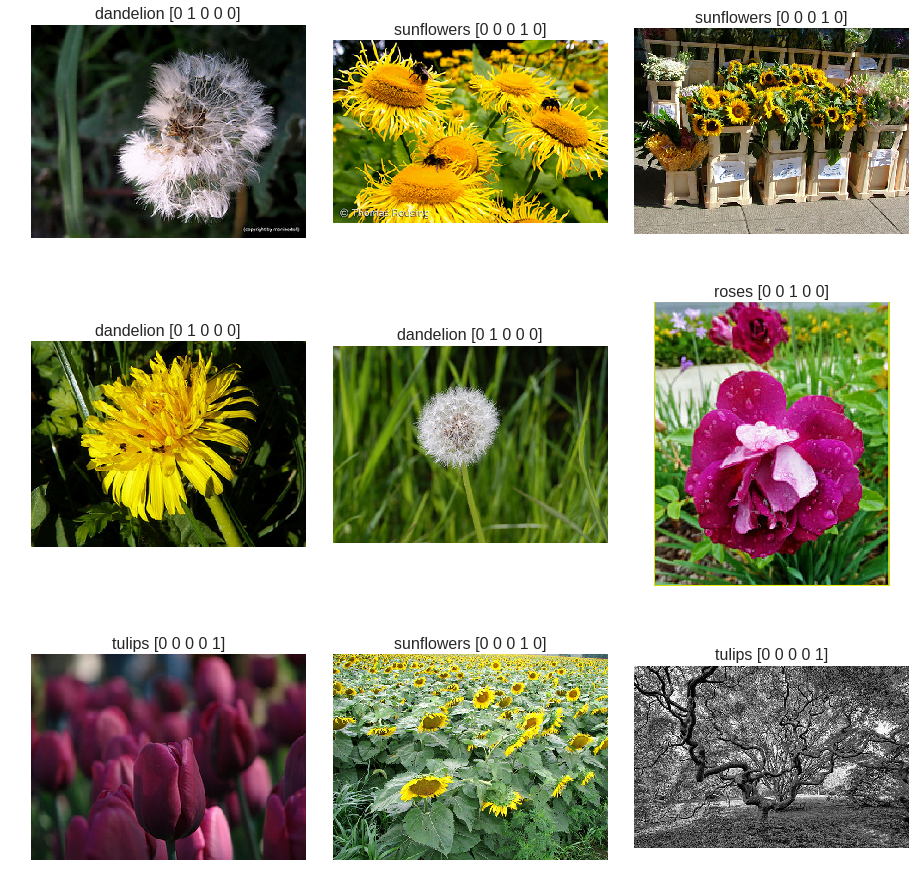

In [0]:
display_9_images_from_dataset(dataset1)

## Resize and crop images to common size

In [0]:
def resize_and_crop_image(image, label, one_hot_label):
  # Resize and crop using "fill" algorithm:
  # always make sure the the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize_images(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize_images(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label, one_hot_label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=32)  

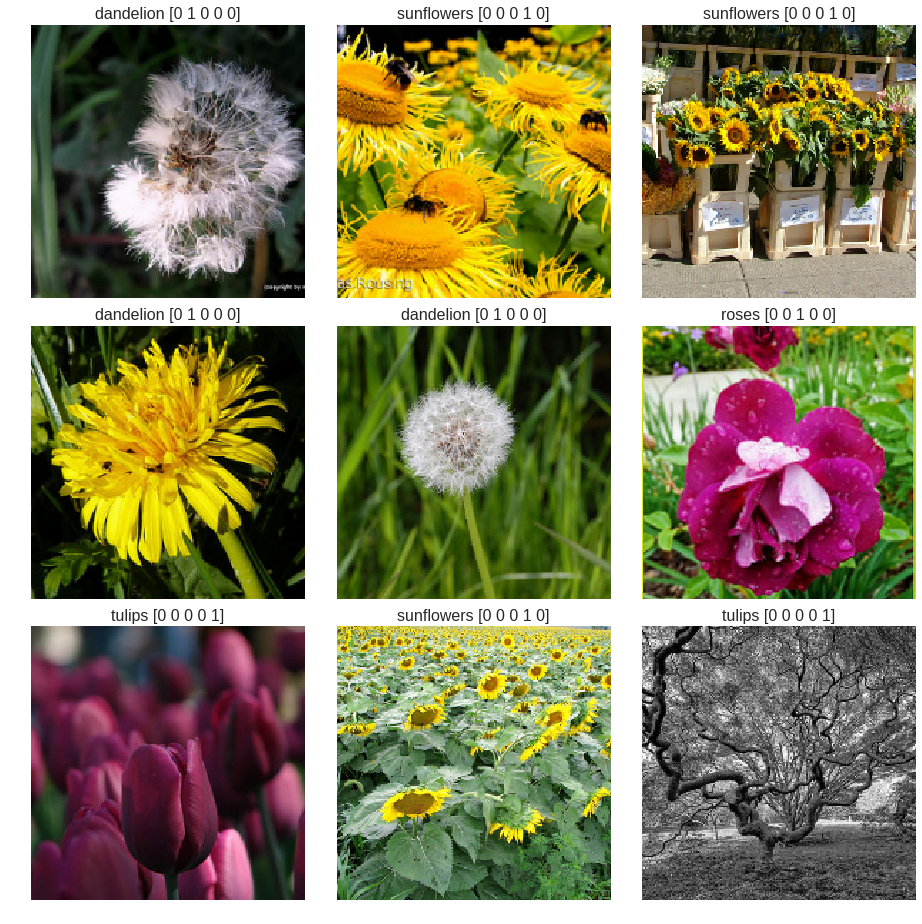

In [0]:
display_9_images_from_dataset(dataset2)

## Last adjustments to images + recompress

In [0]:
def convert_image_to_uint8(image, label, one_hot_label):
  image = tf.cast(image, tf.uint8)  # convert to uint8 before saving
  if RECOMPRESS:
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, one_hot_label

dataset3 = dataset2.map(convert_image_to_uint8, num_parallel_calls=32)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

## Write dataset to TFRecord files

In [0]:
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
  
def to_tfrecord(tfrec_filewriter, img_bytes, label, one_hot_label):
  feature = {
      "image": _bytes_feature(img_bytes),
      "label": _bytes_feature(label),
      "one_hot_label": _bytes_feature(one_hot_label)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
for shard, (images, labels, one_hot_labels) in enumerate(dataset3):
  filename = GCS_OUTPUT + "{:02d}.tfrec".format(shard)
  shard_size = images.numpy().shape[0]
  with tf.python_io.TFRecordWriter(filename) as file:
    for i in range(shard_size):
      example = to_tfrecord(file,
                            images[i].numpy() if RECOMPRESS else images[i].numpy().tobytes(),  # already a byte string if re-compressed, otherwise uont8 to bytes string.
                            labels[i].numpy(), # this is a byte string already
                            one_hot_labels[i].numpy().tobytes())  # uint8 to bytes string
      file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file gs://flowers-public/tfrecords-jpeg-192x192/flowers00.tfrec containing 230 records
Wrote file gs://flowers-public/tfrecords-jpeg-192x192/flowers01.tfrec containing 230 records
Wrote file gs://flowers-public/tfrecords-jpeg-192x192/flowers02.tfrec containing 230 records
Wrote file gs://flowers-public/tfrecords-jpeg-192x192/flowers03.tfrec containing 230 records
Wrote file gs://flowers-public/tfrecords-jpeg-192x192/flowers04.tfrec containing 230 records
Wrote file gs://flowers-public/tfrecords-jpeg-192x192/flowers05.tfrec containing 230 records
Wrote file gs://flowers-public/tfrecords-jpeg-192x192/flowers06.tfrec containing 230 records
Wrote file gs://flowers-public/tfrecords-jpeg-192x192/flowers07.tfrec containing 230 records
Wrote file gs://flowers-public/tfrecords-jpeg-192x192/flowers08.tfrec containing 230 records
Wrote file gs://flowers-public/tfrecords-jpeg-192x192/flowers09.tfrec containing 230 records
Wrote file gs://flowers-public/tfrecords-jpeg-192x19

## TEST: read from the TFRecord Dataset

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.FixedLenFeature((), tf.string),
        "label": tf.FixedLenFeature((), tf.string),
        "one_hot_label": tf.FixedLenFeature((), tf.string)
    }
    example = tf.parse_single_example(example, features)
    if RECOMPRESS:
      image = tf.image.decode_jpeg(example['image'])
    else:
      image = tf.io.decode_raw(example['image'], out_type=tf.uint8)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    label = example['label']  # already a byte string
    one_hot_label = tf.io.decode_raw(example['one_hot_label'], out_type=tf.uint8)
    return image, label, one_hot_label
    
# read from tfrecs
filenames = tf.data.Dataset.list_files(GCS_OUTPUT + "*.tfrec")
records = tf.data.TFRecordDataset(filenames, num_parallel_reads=32)
dataset4 = records.map(read_tfrecord, num_parallel_calls=32)
dataset4 = dataset4.shuffle(300)

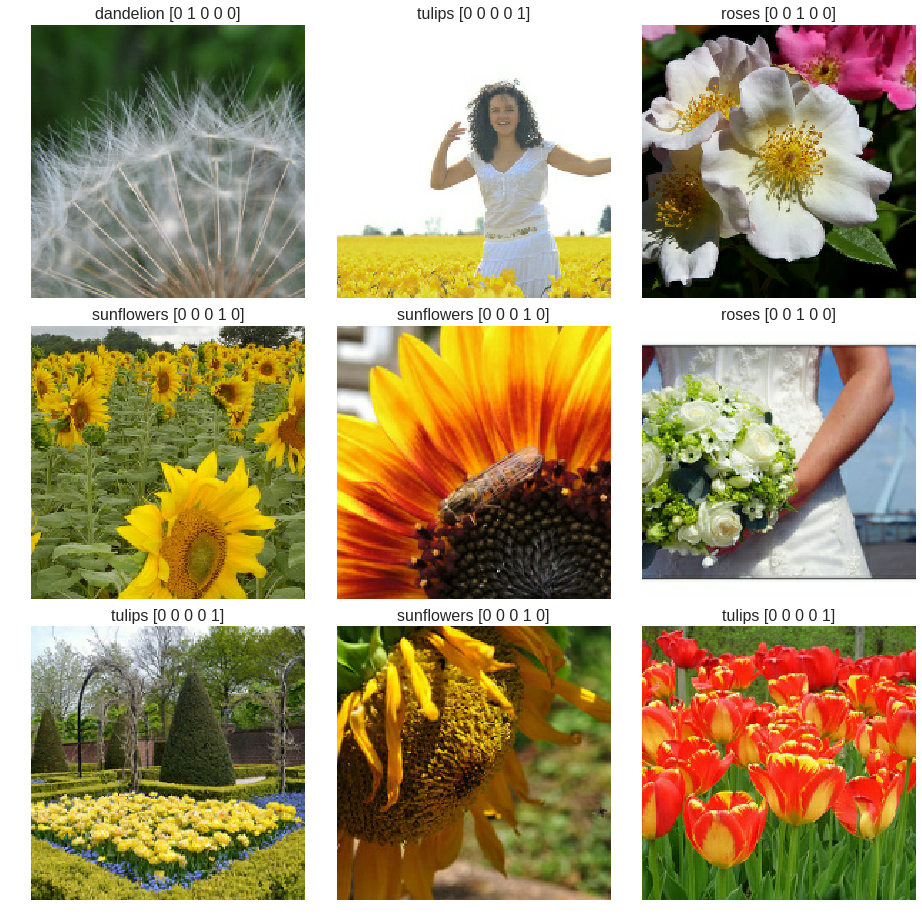

In [0]:
display_9_images_from_dataset(dataset4)